# Milestone 2: Cleaning/Formatting Flat File Source

For my project, I chose daily historical stock price data as my flat source. This data is available on a number of different websites, but I'll be using the historical download section of Yahoo Finance to download the raw CSV files needed to make this project work.

!["Amazon Stock Price"](yahoo_amzn.jpg)

Yahoo allows visitors to download raw stock price data from their website. Users can input their time period of choice, whether or not they want to see stock splits or dividend data, and the frequency at which they want the data to be presented. 


I'll first design a class that allows a user to extract the data from Yahoo Finance using `pd.read_csv`.

## Building a class to pull data from Yahoo Finance
I ran into a couple road blocks for pulling this data. The URL I need to query Yahoo Finances accepts unix timestamps to determine the time range requested. This is fine for anything after 1/1/1970, but several stocks including GE and IBM were listed years before that date. Checking the Yahoo Finance URL for those stocks between those times shows that it intakes a negative unix timestamp; the number of seconds before the epoch. 

Unfortunately, none of the libraries I tried to use (datetime, time, arrow) were able to convert dates into negative timestamps. So I created a function to calculate the number of days since the epoch and multiple that value by the number of seconds per day. This results in a decent estimation of the unix timestamp and works well when trying to query Yahoo Finance

In [1]:
import pandas as pd
import datetime
import numpy as np

In [2]:
def time_to_timestamp(time, last = False):
    """Converts a mm/dd/yyyy formatted time into a unix timestamp including dates before 1/1/1970"""
    epoch = datetime.datetime(1970, 1, 1)  # calculate the epoch timestamp 
    month, day, year = time.split("/") #  extract date info from the string
    if last == True:
        day = str(int(day) + 1)
    t = datetime.datetime(int(year), int(month), int(day)) # Convert the date info to a timestamp
    diff = t-epoch  # Subtract the difference to find how mahy years, months, and days need to be subtracted/added
    return (diff.days * 24 * 60 * 60)  # Finding the number of seconds to calculate the timestamp

In [3]:
print(time_to_timestamp("12/25/2020"))
print(time_to_timestamp("12/25/1920"))

1608854400
-1546905600


I also wanted to add total percentage change to my dataframe, which would compare all the subsequent values of a series to the first value. I originally used `pct_change().cumsum()` but quickly found an error in doing so. 

`pct_change()` finds the difference between adjacent rows. `cumsum()` adds each value to the previous. The problem with using the two together is that percentage differences don't work the same as regular numbers

Let's say we have a stock crash 50% in one day and 50% the next day. 

\\$100 -> \\$50 -> \\$25

In this case, the stock dropped a total of 75% 

(\\$25 / \\$100 ) - 1 == -0.75

Since `pct_change()` would report two 50% drops consecutively, cumsum would add the two together to form 100%, which isn't the correct method.

I needed to create another definition to calculate the total percentage change.

In [4]:
def total_pct_change(series):
    """Computes the total percentage value change since the origin"""
    vals = []
    for i in np.arange(0,len(series)):
        vals.append((series[i]/series[0]) - 1)
    return vals

We can verify our function works properly by passing in an array of numbers from 100 to 10. We should have an ending value of -90% or 0.9

In [5]:
print("testing series")
test = pd.Series(np.linspace(100,10,10))

print("\npct_change().cumsum()")
print(pd.Series(test).pct_change().cumsum() * 100 )

print("\ntotal_pct_change() function")
print(pd.Series(total_pct_change(test)))

testing series

pct_change().cumsum()
0           NaN
1    -10.000000
2    -21.111111
3    -33.611111
4    -47.896825
5    -64.563492
6    -84.563492
7   -109.563492
8   -142.896825
9   -192.896825
dtype: float64

total_pct_change() function
0    0.0
1   -0.1
2   -0.2
3   -0.3
4   -0.4
5   -0.5
6   -0.6
7   -0.7
8   -0.8
9   -0.9
dtype: float64


Finally, we come to the data extraction. I chose to use a class for this portion since I'll be adding a bunch of different utilites and definitions to it. 

I'll build two classes, one for extractng information from one ticker, and one for multiple. Each dataframe will be constructed and `pct_change()` and `total_pct_change()` will be added to the dataframe to make this easier for the user. 

In [6]:
class StockAnalyzer():
   
    def __init__(self):
        # Defining the url to query
        self.url = "https://query1.finance.yahoo.com/v7/finance/download/{}?period1={}&period2={}&interval=1{}&events=history&includeAdjustedClose=true"
    
    def get_price(self, 
                 ticker, 
                 start = '1/1/1900', 
                 end = datetime.date.today().strftime('%m/%d/%Y') , 
                 freq = "d"):
        
        """Returns the daily stock prices of a single ticker within a defined timerange. """
        start = time_to_timestamp(start) 
        # End Time
        end = time_to_timestamp(end, last = True)
        stock_price = pd.read_csv(self.url.format(ticker,
                                                  start,
                                                  end,
                                                  freq), index_col=0)
        
        stock_price['PctChange'] = stock_price['Adj Close'].pct_change()
        stock_price['CumPctChange'] = total_pct_change(stock_price['Adj Close'])
        
        stock_price['Ticker'] = ticker
        
        cols = stock_price.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        stock_price = stock_price[cols]
        
        return stock_price
    

In [7]:
stocks = StockAnalyzer()

ibm_prices = stocks.get_price(ticker = "IBM", 
              start = "1/22/1962", 
              end = "1/19/1973", 
              freq = "d")
ibm_prices

,Ticker,Open,High,Low,Close,Adj Close,Volume,PctChange,CumPctChange
Date,,,,,,,,,
1962-01-22,IBM,7.380000,7.453333,7.360000,7.366667,1.787817,275200,NaN,0.000000
1962-01-23,IBM,7.363333,7.373333,7.280000,7.293334,1.770019,371200,-0.009955,-0.009955
1962-01-24,IBM,7.293334,7.333333,7.256667,7.333333,1.779728,408000,0.005485,-0.004525
1962-01-25,IBM,7.333333,7.393333,7.240000,7.253334,1.760312,315200,-0.010910,-0.015385
1962-01-26,IBM,7.253334,7.280000,7.213333,7.216667,1.751413,243200,-0.005055,-0.020362
...,...,...,...,...,...,...,...,...,...
1973-01-15,IBM,21.137501,21.450001,21.137501,21.162500,5.498196,1372800,0.007738,2.075368
1973-01-16,IBM,21.162500,21.237499,21.037500,21.125000,5.488451,907200,-0.001772,2.069918
1973-01-17,IBM,21.125000,21.212500,21.037500,21.200001,5.507938,417600,0.003551,2.080818


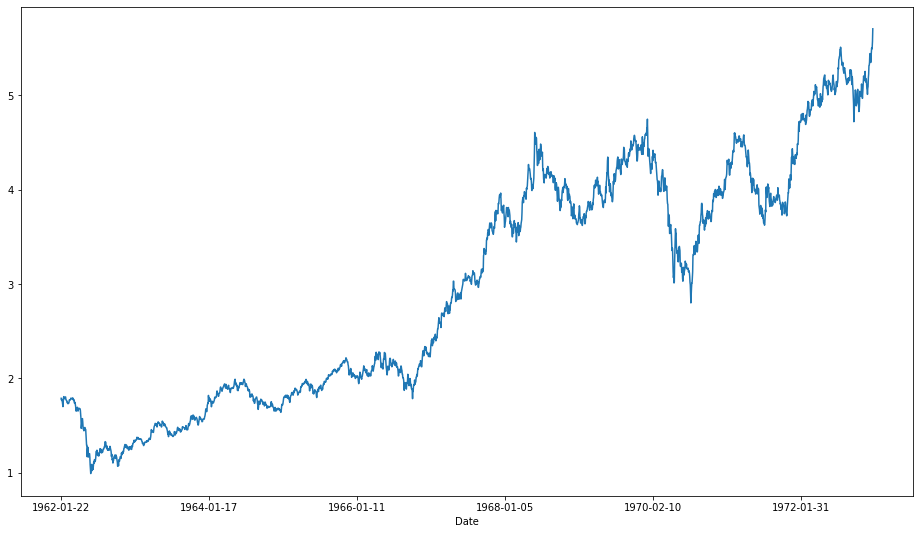

In [8]:
ibm_prices['Adj Close'].plot(figsize=(16,9));

## Building a class to pull data for multiple tickers

Since we will be analyzing mulitple stocks, I also set up a class to pull data for multiple tickers. Each query is added to the same dataframe along with the ticker information as to avoid mixing the stock prices. `pct_change` and `total_price_change()` are also added to the dataframe, but before concatenation to avoid creating a mess.

In [9]:
class StockAnalyzer():
   
    def __init__(self):
        # Defining the url to query
        self.url = "https://query1.finance.yahoo.com/v7/finance/download/{}?period1={}&period2={}&interval=1{}&events=history&includeAdjustedClose=true"
    
    def get_price(self, 
                 ticker, 
                 start = '1/1/1900', 
                 end = datetime.date.today().strftime('%m/%d/%Y') , 
                 freq = "d"):
        """Returns the daily stock prices of a single ticker within a defined timerange. """
        start = time_to_timestamp(start) 
        # End Time
        end = time_to_timestamp(end, last = True)
        stock_price = pd.read_csv(self.url.format(ticker,
                                                  start,
                                                  end,
                                                  freq), index_col=0)
        
        stock_price['PctChange'] = stock_price['Adj Close'].pct_change()
        stock_price['CumPctChange'] = total_pct_change(stock_price['Adj Close'])
        
        stock_price['Ticker'] = ticker
        
        cols = stock_price.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        stock_price = stock_price[cols]
        
        return stock_price
    
        
    def get_prices(self, 
                   tickers, 
                   start = '1/1/1900', 
                   end = datetime.date.today().strftime('%m/%d/%Y') , 
                   freq = "d"):
        """Returns the daily stock prices of multiple tickers within a defined timerange."""
        start = time_to_timestamp(start) 
        # End Time
        end = time_to_timestamp(end, last = True)
        df = pd.DataFrame()
        for i in tickers:
            stock_price = pd.read_csv(self.url.format(i,
                                                  start,
                                                  end,
                                                  freq), index_col=0 )
            
            stock_price['PctChange'] = stock_price['Adj Close'].pct_change()
            stock_price['CumPctChange'] = total_pct_change(stock_price['Adj Close'])
            stock_price['Ticker'] = i
            df = pd.concat([df, stock_price])
            
        # Reordering the column names
        cols = df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        df.index = pd.to_datetime(df.index)
        df = df[cols]
        return df

The output is identical to the previous dataframe with each date and ticker having it's own row. 

In [10]:
stocks = StockAnalyzer()

faang_prices = stocks.get_prices(tickers = ['FB','AAPL','AMZN','NFLX','GOOG'],
                 start = "1/1/2010", 
                 freq = "d" )
faang_prices

,Ticker,Open,High,Low,Close,Adj Close,Volume,PctChange,CumPctChange
Date,,,,,,,,,
2012-05-18,FB,42.049999,45.000000,38.000000,38.230000,38.230000,573576400,NaN,0.000000
2012-05-21,FB,36.529999,36.660000,33.000000,34.029999,34.029999,168192700,-0.109861,-0.109861
2012-05-22,FB,32.610001,33.590000,30.940001,31.000000,31.000000,101786600,-0.089039,-0.189118
2012-05-23,FB,31.370001,32.500000,31.360001,32.000000,32.000000,73600000,0.032258,-0.162961
2012-05-24,FB,32.950001,33.209999,31.770000,33.029999,33.029999,50237200,0.032187,-0.136019
...,...,...,...,...,...,...,...,...,...
2021-01-15,GOOG,1738.189941,1756.000000,1721.550049,1736.189941,1736.189941,1342200,-0.002293,4.561061
2021-01-19,GOOG,1752.250000,1809.275024,1741.459961,1790.859985,1790.859985,1734600,0.031489,4.736171
2021-01-20,GOOG,1831.459961,1903.709961,1825.530029,1886.900024,1886.900024,2490300,0.053628,5.043790


We can plot all of our stock prices against each other to compare the values

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

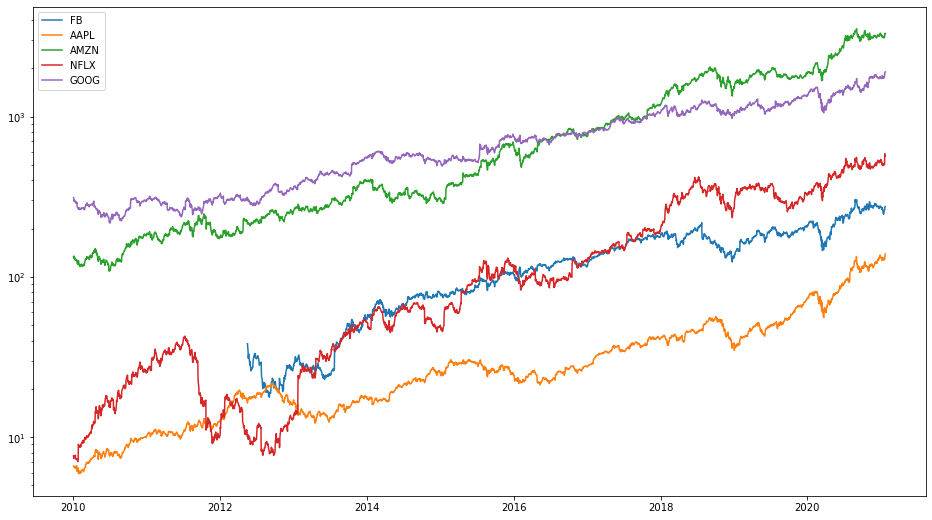

In [12]:
plt.figure(figsize=(16,9))
for i in faang_prices['Ticker'].unique():
    subset = faang_prices[faang_prices['Ticker'] == i]
    plt.plot(subset.index, subset['Adj Close'])
    plt.yscale("log")

plt.legend(labels = faang_prices['Ticker'].unique())    
plt.show()

And we can also plot the total percentage change of each of the stocks to see which one performs the best within our time range.

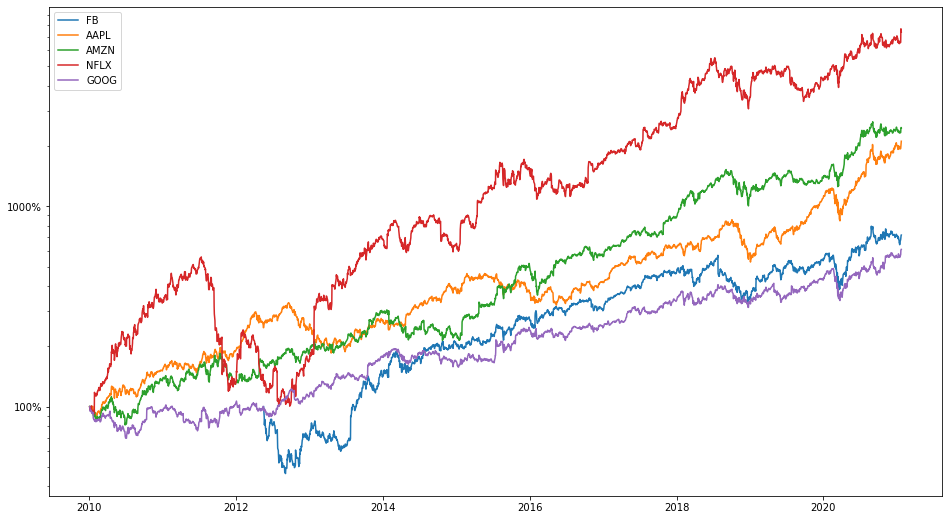

In [13]:
plt.figure(figsize=(16,9))
for i in faang_prices['Ticker'].unique():
    subset = faang_prices[faang_prices['Ticker'] == i]
    plt.plot(pd.to_datetime(subset.index), subset['CumPctChange'] + 1)  # +1 is needed here because I chose to use a log chart
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.legend(labels = faang_prices['Ticker'].unique())    
plt.show()

We can also plot the daily price changes, but this data is very noisy. It's much better to use a histogram

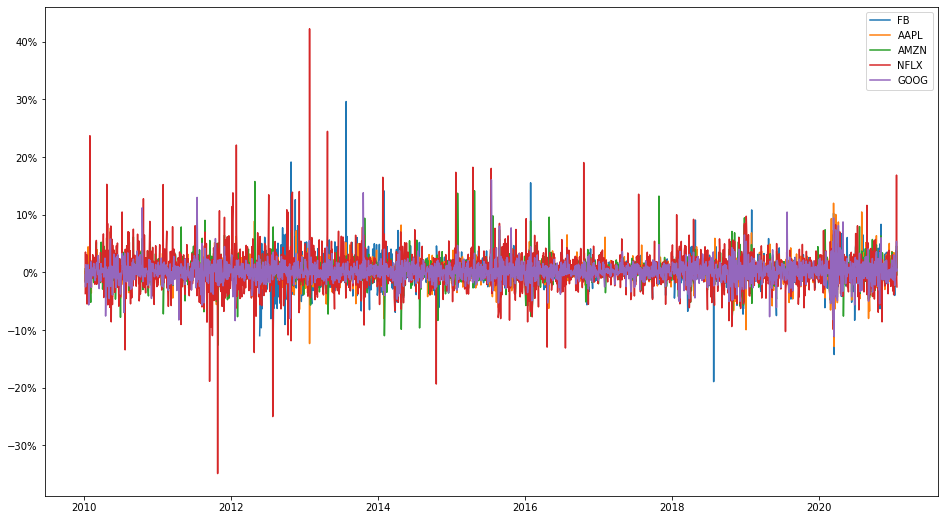

In [14]:
plt.figure(figsize=(16,9))
for i in faang_prices['Ticker'].unique():
    subset = faang_prices[faang_prices['Ticker'] == i]
    plt.plot(pd.to_datetime(subset.index), subset['PctChange'])
    
plt.legend(labels = faang_prices['Ticker'].unique())    
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

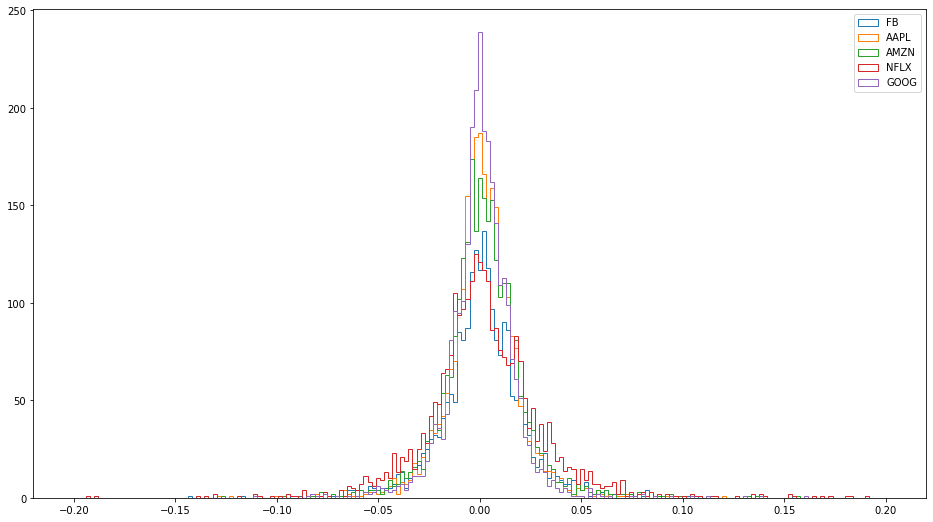

In [15]:
plt.figure(figsize=(16,9))
for i in faang_prices['Ticker'].unique():
    subset = faang_prices[faang_prices['Ticker'] == i][1:]
    plt.hist(subset['PctChange'], bins = np.linspace(-0.2,0.2, 200), histtype="step")
    
plt.legend(labels = faang_prices['Ticker'].unique())
plt.show()

We can also use corrplot to see if values like Volume and Adj Close are correlated. Open, High, Low and Close will all be highly correlated since they are usually pretty close

In [16]:
import seaborn as sns
faang_prices.corr().style.background_gradient(cmap='coolwarm')

,Open,High,Low,Close,Adj Close,Volume,PctChange,CumPctChange
Open,1.000000,0.999921,0.999894,0.999818,0.999818,-0.286138,-0.002840,0.180908
High,0.999921,1.000000,0.999864,0.999908,0.999907,-0.285962,0.000232,0.182052
Low,0.999894,0.999864,1.000000,0.999915,0.999914,-0.286448,0.000828,0.179649
Close,0.999818,0.999908,0.999915,1.000000,0.999999,-0.286234,0.004265,0.180953
Adj Close,0.999818,0.999907,0.999914,0.999999,1.000000,-0.287104,0.004268,0.181079
Volume,-0.286138,-0.285962,-0.286448,-0.286234,-0.287104,1.000000,-0.012420,-0.148591
PctChange,-0.002840,0.000232,0.000828,0.004265,0.004268,-0.012420,1.000000,0.015481
CumPctChange,0.180908,0.182052,0.179649,0.180953,0.181079,-0.148591,0.015481,1.000000


We could instead compare each company against the other by pivoting our data and checking the correlation. Highly correlated companies will often be in the same sector. 

In [17]:
faang_prices.pivot(columns='Ticker', values="Adj Close")

Ticker,AAPL,AMZN,FB,GOOG,NFLX
Date,,,,,
2010-01-04,6.593426,133.899994,NaN,312.204773,7.640000
2010-01-05,6.604825,134.690002,NaN,310.829926,7.358572
2010-01-06,6.499768,132.250000,NaN,302.994293,7.617143
2010-01-07,6.487752,130.000000,NaN,295.940735,7.485714
2010-01-08,6.530883,133.520004,NaN,299.885956,7.614286
...,...,...,...,...,...
2021-01-15,127.139999,3104.250000,251.360001,1736.189941,497.980011
2021-01-19,127.830002,3120.760010,261.100006,1790.859985,501.769989
2021-01-20,132.029999,3263.379883,267.480011,1886.900024,586.340027


In [18]:
faang_prices.pivot(columns='Ticker', values="Adj Close").corr().style.background_gradient(cmap='coolwarm')

Ticker,AAPL,AMZN,FB,GOOG,NFLX
Ticker,,,,,
AAPL,1.000000,0.958534,0.880409,0.920908,0.921126
AMZN,0.958534,1.000000,0.931625,0.959766,0.984891
FB,0.880409,0.931625,1.000000,0.975644,0.932228
GOOG,0.920908,0.959766,0.975644,1.000000,0.959016
NFLX,0.921126,0.984891,0.932228,0.959016,1.000000


## Pulling another flat dataset for info on companies

This will technically count as web scraping, but I wanted to also create a dataframe containing info relating to what sectors these companies are in as well as their market cap.

This still needs to be cleaned up a lot, so I'll also include it in the Milestone 3 Report

!["FinViz"](FinViz.jpg)

In [19]:
from IPython.display import clear_output
import requests

class StockAnalyzer():
   
    def __init__(self):
        # Defining the url to query
        self.url = "https://query1.finance.yahoo.com/v7/finance/download/{}?period1={}&period2={}&interval=1{}&events=history&includeAdjustedClose=true"
        self.header = { "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 \
        (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36", 
                  "X-Requested-With": "XMLHttpRequest" }
        self.screener_url = "https://finviz.com/screener.ashx?v=111"
        
    
    def get_price(self, 
                 ticker, 
                 start = '1/1/1900', 
                 end = datetime.date.today().strftime('%m/%d/%Y') , 
                 freq = "d"):
        """Returns the daily stock prices of a single ticker within a defined timerange. """
        start = time_to_timestamp(start) 
        # End Time
        end = time_to_timestamp(end, last = True)
        stock_price = pd.read_csv(self.url.format(ticker,
                                                  start,
                                                  end,
                                                  freq), index_col=0)
        
        stock_price['PctChange'] = stock_price['Adj Close'].pct_change()
        stock_price['CumPctChange'] = total_pct_change(stock_price['Adj Close'])
        
        stock_price['Ticker'] = ticker
        
        cols = stock_price.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        stock_price = stock_price[cols]
        
        return stock_price
    
        
    def get_prices(self, 
                   tickers, 
                   start = '1/1/1900', 
                   end = datetime.date.today().strftime('%m/%d/%Y') , 
                   freq = "d"):
        
        """Returns the daily stock prices of multiple tickers within a defined timerange."""
        start = time_to_timestamp(start) 
        # End Time
        end = time_to_timestamp(end, last = True)
        df = pd.DataFrame()
        for i in tickers:
            stock_price = pd.read_csv(self.url.format(i,
                                                  start,
                                                  end,
                                                  freq), index_col=0 )
            
            stock_price['PctChange'] = stock_price['Adj Close'].pct_change()
            stock_price['CumPctChange'] = total_pct_change(stock_price['Adj Close'])
            stock_price['Ticker'] = i
            df = pd.concat([df, stock_price])
            
        # Reordering the column names
        cols = df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        df.index = pd.to_datetime(df.index)
        df = df[cols]
        return df


    def get_data(self, debug=False):
        """Returns a dataframe containing company name, ticker, industry, sector and market cap"""
        df = pd.DataFrame()
        for i in np.arange(1,7621, 20):
            self.screener_url = "https://finviz.com/screener.ashx?v=111"
            if debug == True:
                clear_output(wait=True)
                print("{:.2f}% Complete".format((i/7601) * 100))
            self.screener_url = self.screener_url + "&r={}".format(i)
            html_page_text = requests.get(self.screener_url, headers=self.header);
            temp = pd.DataFrame(pd.read_html(html_page_text.text, na_values="-")[14])
            new_header = temp.iloc[0] #grab the first row for the header
            temp = temp[1:] #take the data less the header row
            temp.columns = new_header #set the header row as the df header
            df = pd.concat([df,temp])
        return df

This can take a few minutes to run, so I added a little feature to give us some indication of how far along our program is

In [20]:
stocks = StockAnalyzer()
df = stocks.get_data(debug=True)

100.00% Complete


In [21]:
df

,No.,Ticker,Company,Sector,Industry,Country,Market Cap,P/E,Price,Change,Volume
1,1,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,USA,38.71B,54.88,126.33,-0.53%,1438626
2,2,AA,Alcoa Corporation,Basic Materials,Aluminum,USA,3.89B,NaN,19.40,-3.05%,11170735
3,3,AAAU,Goldman Sachs Physical Gold ETF,Financial,Exchange Traded Fund,USA,NaN,NaN,18.47,-0.81%,539733
4,4,AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,China,42.86M,NaN,1.35,-3.57%,80823
5,5,AACQ,Artius Acquisition Inc.,Financial,Shell Companies,USA,799.12M,NaN,11.03,0.64%,1064973
...,...,...,...,...,...,...,...,...,...,...,...
6,7606,ZUO,"Zuora, Inc.",Technology,Software - Infrastructure,USA,1.84B,NaN,15.05,1.21%,2011936
7,7607,ZVO,Zovio Inc,Consumer Defensive,Education & Training Services,USA,171.11M,NaN,5.50,2.42%,174691
8,7608,ZYME,Zymeworks Inc.,Healthcare,Biotechnology,Canada,2.42B,NaN,52.16,0.44%,418907
9,7609,ZYNE,"Zynerba Pharmaceuticals, Inc.",Healthcare,Drug Manufacturers - Specialty & Generic,USA,107.19M,NaN,3.58,0.00%,1441550


We are only interested in the Tickers, Company Name, Sector, Industry, Country, and Market Cap, so we can drop the rest of the columns.

In [22]:
df = df.drop(['P/E', 'Price', 'Change', 'Volume'], axis=1)
df

,No.,Ticker,Company,Sector,Industry,Country,Market Cap
1,1,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,USA,38.71B
2,2,AA,Alcoa Corporation,Basic Materials,Aluminum,USA,3.89B
3,3,AAAU,Goldman Sachs Physical Gold ETF,Financial,Exchange Traded Fund,USA,NaN
4,4,AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,China,42.86M
5,5,AACQ,Artius Acquisition Inc.,Financial,Shell Companies,USA,799.12M
...,...,...,...,...,...,...,...
6,7606,ZUO,"Zuora, Inc.",Technology,Software - Infrastructure,USA,1.84B
7,7607,ZVO,Zovio Inc,Consumer Defensive,Education & Training Services,USA,171.11M
8,7608,ZYME,Zymeworks Inc.,Healthcare,Biotechnology,Canada,2.42B
9,7609,ZYNE,"Zynerba Pharmaceuticals, Inc.",Healthcare,Drug Manufacturers - Specialty & Generic,USA,107.19M


I wanted a way to convert the market cap into an integer so calculations could be performed on it. This is what I ended up with

This will eventually go into the class to make the data more seamless

In [23]:
def string_to_int(string):
    """Converts short format string values (100M/ 10B) into integers"""
    multipliers = {'K':1000, 'M':1000000, 'B':1000000000, 'T':1000000000000}
    if pd.isnull(string):
        return np.nan
    if str(string)[-1].isdigit(): # check if no suffix
        return int(string)
    mult = multipliers[string[-1].upper()] # look up suffix to get multiplier
     # convert number to float, multiply by multiplier, then make int
    return int(float(string[:-1]) * mult)

In [24]:
df['Market Cap'] = df['Market Cap'].apply(string_to_int)
df

,No.,Ticker,Company,Sector,Industry,Country,Market Cap
1,1,A,"Agilent Technologies, Inc.",Healthcare,Diagnostics & Research,USA,3.871000e+10
2,2,AA,Alcoa Corporation,Basic Materials,Aluminum,USA,3.890000e+09
3,3,AAAU,Goldman Sachs Physical Gold ETF,Financial,Exchange Traded Fund,USA,NaN
4,4,AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,China,4.286000e+07
5,5,AACQ,Artius Acquisition Inc.,Financial,Shell Companies,USA,7.991200e+08
...,...,...,...,...,...,...,...
6,7606,ZUO,"Zuora, Inc.",Technology,Software - Infrastructure,USA,1.840000e+09
7,7607,ZVO,Zovio Inc,Consumer Defensive,Education & Training Services,USA,1.711100e+08
8,7608,ZYME,Zymeworks Inc.,Healthcare,Biotechnology,Canada,2.420000e+09
9,7609,ZYNE,"Zynerba Pharmaceuticals, Inc.",Healthcare,Drug Manufacturers - Specialty & Generic,USA,1.071900e+08


Checking which company is the largest

In [25]:
df[df['Market Cap'] == np.max(df['Market Cap'])]

,No.,Ticker,Company,Sector,Industry,Country,Market Cap
15,15,AAPL,Apple Inc.,Technology,Consumer Electronics,USA,2.372180e+12


Pulling the top 20 largest companies 

In [26]:
df.sort_values(['Market Cap'], ascending=False)[:20]

,No.,Ticker,Company,Sector,Industry,Country,Market Cap
15,15,AAPL,Apple Inc.,Technology,Consumer Electronics,USA,2.372180e+12
10,4530,MSFT,Microsoft Corporation,Technology,Software - Infrastructure,USA,1.711270e+12
6,326,AMZN,"Amazon.com, Inc.",Consumer Cyclical,Internet Retail,USA,1.664220e+12
2,2942,GOOG,Alphabet Inc.,Communication Services,Internet Content & Information,USA,1.305000e+12
3,2943,GOOGL,Alphabet Inc.,Communication Services,Internet Content & Information,USA,1.285980e+12
2,6822,TSLA,"Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,USA,8.025300e+11
18,2338,FB,"Facebook, Inc.",Communication Services,Internet Content & Information,USA,7.640700e+11
1,601,BABA,Alibaba Group Holding Limited,Consumer Cyclical,Internet Retail,China,6.983500e+11
18,898,BRK-B,Berkshire Hathaway Inc.,Financial,Insurance - Diversified,USA,5.660000e+11
4,6824,TSM,Taiwan Semiconductor Manufacturing Company Lim...,Technology,Semiconductors,Taiwan,5.656600e+11


In [27]:
top_20 = list(df.sort_values(['Market Cap'], ascending=False)[:20]['Ticker'].values)
print(top_20)

['AAPL', 'MSFT', 'AMZN', 'GOOG', 'GOOGL', 'TSLA', 'FB', 'BABA', 'BRK-B', 'TSM', 'BRK-A', 'V', 'JNJ', 'WMT', 'JPM', 'NVDA', 'MA', 'UNH', 'PG', 'DIS']


In [28]:
top_20_df = stocks.get_prices(tickers=top_20,
           start = "1/1/2020", 
           freq = "d")

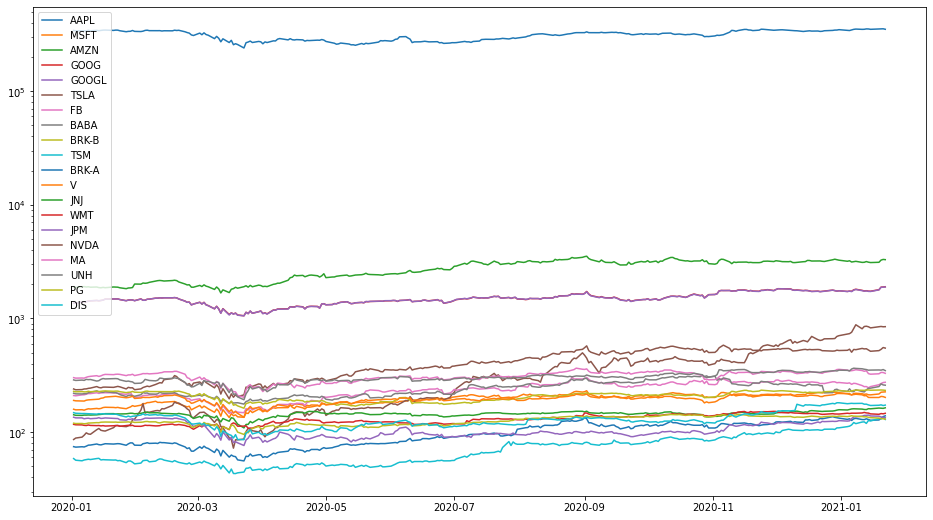

In [29]:
plt.figure(figsize=(16,9))
for i in top_20_df['Ticker'].unique():
    subset = top_20_df[top_20_df['Ticker'] == i]
    plt.plot(pd.to_datetime(subset.index), subset['Adj Close'])
    plt.yscale("log")

plt.legend(labels = top_20_df['Ticker'].unique())    
plt.show()

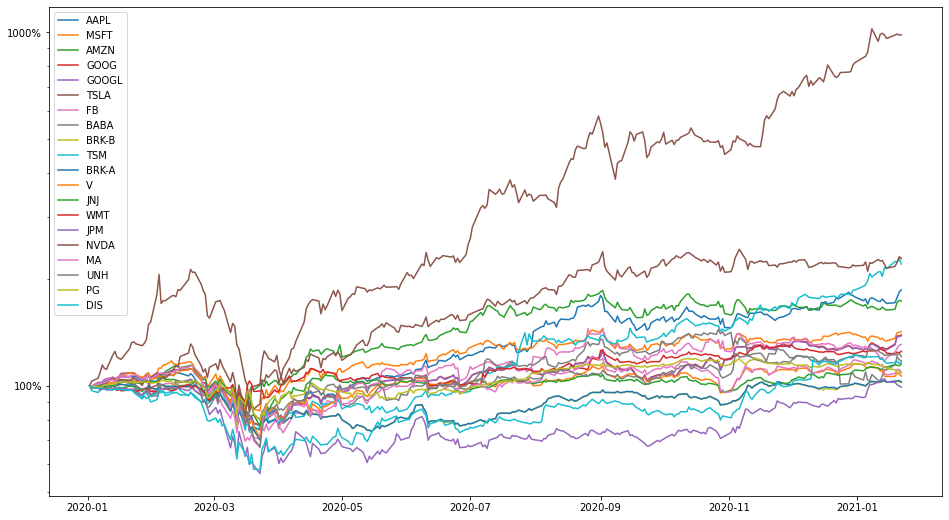

In [30]:
plt.figure(figsize=(16,9))
for i in top_20_df['Ticker'].unique():
    subset = top_20_df[top_20_df['Ticker'] == i]
    plt.plot(pd.to_datetime(subset.index), subset['CumPctChange'] + 1)
plt.yscale("log")    
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.legend(labels = top_20_df['Ticker'].unique())    
plt.show()

Checking for company price correlation

Companies like Berkshire Hathaway and Google have two seperate stock tickers, so they will be highly correlated with themselves

In [31]:
top_20_df.pivot(columns='Ticker', values="Adj Close").corr().style.background_gradient(cmap='coolwarm')

Ticker,AAPL,AMZN,BABA,BRK-A,BRK-B,DIS,FB,GOOG,GOOGL,JNJ,JPM,MA,MSFT,NVDA,PG,TSLA,TSM,UNH,V,WMT
Ticker,,,,,,,,,,,,,,,,,,,,
AAPL,1.000000,0.916610,0.815357,0.589100,0.583600,0.689227,0.933046,0.883778,0.881126,0.655400,0.283826,0.809814,0.934152,0.956892,0.911976,0.916815,0.925632,0.879506,0.756076,0.891135
AMZN,0.916610,1.000000,0.833701,0.282779,0.277948,0.410829,0.893292,0.752069,0.751299,0.560630,-0.043312,0.656152,0.964912,0.957415,0.813681,0.798121,0.783698,0.780845,0.601754,0.868007
BABA,0.815357,0.833701,1.000000,0.448337,0.446346,0.351054,0.856650,0.670934,0.668651,0.392388,0.061017,0.693289,0.806591,0.865517,0.879040,0.627133,0.674759,0.667644,0.589911,0.758940
BRK-A,0.589100,0.282779,0.448337,1.000000,0.999393,0.850512,0.538542,0.699974,0.695937,0.561554,0.851241,0.775259,0.400274,0.426308,0.700788,0.577004,0.660444,0.632588,0.741499,0.469955
BRK-B,0.583600,0.277948,0.446346,0.999393,1.000000,0.845567,0.534193,0.695369,0.691382,0.558082,0.851109,0.773714,0.395670,0.421152,0.699021,0.569993,0.654439,0.627797,0.739456,0.466123
DIS,0.689227,0.410829,0.351054,0.850512,0.845567,1.000000,0.619143,0.822237,0.821274,0.702667,0.834693,0.762478,0.542945,0.511619,0.627540,0.749757,0.776129,0.759644,0.792174,0.547218
FB,0.933046,0.893292,0.856650,0.538542,0.534193,0.619143,1.000000,0.889611,0.889993,0.623074,0.257001,0.848338,0.928393,0.915271,0.876944,0.768445,0.789797,0.869420,0.823942,0.812914
GOOG,0.883778,0.752069,0.670934,0.699974,0.695369,0.822237,0.889611,1.000000,0.999795,0.720544,0.555057,0.828287,0.850341,0.808281,0.816780,0.849138,0.873492,0.931811,0.863060,0.798576
GOOGL,0.881126,0.751299,0.668651,0.695937,0.691382,0.821274,0.889993,0.999795,1.000000,0.719938,0.555024,0.828986,0.851015,0.805360,0.812779,0.844153,0.869156,0.931739,0.865571,0.793083
